In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext line_profiler

In [190]:
from ase.io import read
from ase.visualize import view
from ase.units import Hartree
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

# import rascaline.torch

import metatensor.torch as mts

from metatensor.torch import Labels, TensorBlock, TensorMap
from metatensor.learn import IndexedDataset, DataLoader
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts

from mlelec.data.dataset import QMDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
# from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
# from mlelec.features.acdc import compute_features
from mlelec.utils.target_utils import get_targets
from mlelec.models.linear import LinearModelPeriodic
from mlelec.metrics import L2_loss, L2_loss_meanzero
# import xitorch
# from xitorch.linalg import symeig

from glob import glob

from scipy.linalg import eigvalsh
from pathlib import Path
# from mlelec.utils.pbc_utils import  TMap_bloch_sums_feat
plt.rcParams['figure.figsize'] = 2*1.618, 2
plt.rcParams['figure.dpi'] = 300

In [191]:
from mlelec.utils.pbc_utils import move_orbitals_to_keys

In [192]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [193]:
root = '/scratch/pegolo/seed_73'
workdir = f'{root}/test_integrated_model'
resdir = f'{workdir}/results'
device = 'cpu'
cutoff = 8
overwrite = True

Path(resdir).mkdir(exist_ok = overwrite)
orbitals = {6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]}
orbital_names = 'sto-3g'


kmesh = [8,8,1]

# Load checkpoints

In [194]:
checkpoints = {}

start = 0

for space in ['real_space', 'kspace']:
    checkpoints[space] = {}
    strategies = [s.split('/')[-1] for s in glob(f'{workdir}/{space}/*')]
    
    for strategy in strategies:
        checkpoints[space][strategy] = {}
        stops = sorted([int(s.split('/')[-1].split('_')[-1]) for s in glob(f'{workdir}/{space}/{strategy}/train_{start}_*')])
        
        for stop in stops:
            folder = f'{workdir}/{space}/{strategy}/train_{start}_{stop}'
            try:
                nbest = max([int(f.split('/')[-1].split('.')[0].split('_')[1]) for f in glob(f'{folder}/model*ckpt')])
                print(space, strategy, stop, nbest)
                checkpoints[space][strategy][stop] = torch.load(f'{folder}/model_{nbest}.ckpt')
            except:
                print(f'No useful data in {folder}')

real_space a 1 120
real_space a 3 200
real_space a 5 960
real_space a 7 980
real_space a 9 260
real_space a 11 480
real_space a 13 680
real_space a 15 600
real_space a 17 740
real_space a 19 760
real_space a 20 940
real_space a 40 1060
real_space a 60 1280
real_space a 80 640
real_space a 100 1240
real_space a 120 1140
real_space a 140 1160
real_space a_usual 20 260
real_space a_usual 60 240
real_space a_usual 100 360
kspace d 1 120
kspace d 3 280
kspace d 5 4940
kspace d 7 1320
kspace d 9 360
kspace d 11 540
kspace d 13 640
kspace d 15 480
kspace d 17 620
kspace d 19 760
kspace d 20 740
kspace d 40 880
kspace d 60 1160
kspace d 80 800
kspace d 100 820
kspace d 120 520
kspace d 140 1260
kspace d_usual 20 440
kspace d_usual 60 600
kspace d_usual 100 640


# Test dataset

In [195]:
# Define dataset
START, STOP = 140, 172
indices = np.loadtxt(f'{root}/random_indices.txt', dtype = int)[START:STOP]
frames = [read(f'{root}/test/C2_174.extxyz', index = i) for i in indices]
rfock = [np.load(f"{root}/test/data/scf/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rfock0 = [np.load(f"{root}/test/data/baseline/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rover = [np.load(f"{root}/test/data/scf/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in indices]

dataset = QMDataset(frames = frames,
                    kmesh = kmesh,
                    dimension = 2,
                    fock_realspace = rfock,
                    overlap_realspace = rover,
                    device = device,
                    orbs = orbitals,
                    orbs_name = orbital_names)

## Test targets

In [196]:
_, test_coupled_blocks = get_targets(dataset, cutoff = 8)
phase, _ ,_= precompute_phase(test_coupled_blocks, dataset)
test_coupled_blocks_k = TMap_bloch_sums(test_coupled_blocks, phase, return_tensormap=True)

In [197]:
ntest = sum([np.prod(b.values.shape) for b in test_coupled_blocks.blocks()])

In [198]:
_, overlap_blocks = get_targets(dataset, cutoff = 8, target = 'overlap')
Sk = dataset.bloch_sum(blocks_to_matrix(overlap_blocks, dataset))

In [199]:
target_keynames = test_coupled_blocks.keys.names
keys = []
blocks= []
for k,b in test_coupled_blocks.items(): 
    li,lj, L = k['l_i'], k['l_j'], k['L']
    inversion_sigma = (-1) ** (li + lj + L)
    keys.append(torch.cat((k.values, torch.tensor([inversion_sigma]))))
    blocks.append(b.copy())
test_coupled_blocks_integrated = TensorMap(Labels(k.names+['inversion_sigma'], torch.stack(keys)), blocks)
test_coupled_blocks_integrated_copy = test_coupled_blocks_integrated.copy()
test_coupled_blocks_integrated = test_coupled_blocks_integrated.keys_to_properties(['n_i', 'l_i',  'n_j','l_j'])

In [200]:
int_phase, _,_ = precompute_phase(test_coupled_blocks_integrated, dataset)
test_coupled_blocks_integrated_k = TMap_bloch_sums(test_coupled_blocks_integrated, int_phase)

In [201]:
test_Hk = dataset.bloch_sum(blocks_to_matrix(test_coupled_blocks, dataset, detach = True))
ev_ = []
for H, S in zip(test_Hk, Sk):
    ev__ = []
    for ik in range(len(H)):
        ev__.append(eigvalsh(H[ik].detach().numpy(), S[ik]))
    ev_.append(ev__)
test_eigenvalues = np.array(ev_)

## Test features

In [202]:
test_features = mts.load(f'{root}/test/features_140_172_seed73')

# Models performance

In [206]:
from mlelec.models.linear import LinearModelPeriodic
nhidden = 9
model_usual = LinearModelPeriodic(twocfeat = test_features,
                            target_blocks = test_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True, #True
                            nhidden = nhidden, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

print(f'Usual model with {count_parameters(model_usual)} parameters.')

from mlelec.models.linear_integrated import LinearModelPeriodic
nhidden = 16
model_integrated = LinearModelPeriodic(twocfeat = test_features,
                                        target_blocks = test_coupled_blocks_integrated,
                                        frames = dataset.structures, orbitals = dataset.basis, 
                                        device = device,
                                        bias = True,
                                        nhidden = nhidden, 
                                        nlayers = 1,
                                        activation = 'SiLU',
                                        apply_norm = True
                                       )

print(f'Integrated model with {count_parameters(model_integrated)} parameters.')

Usual model with 74304 parameters.
Integrated model with 71577 parameters.


In [207]:
eigenvalues = {}
predicted_Hk = {}
learning_curve = {}

for space in checkpoints:
    eigenvalues[space] = {}
    predicted_Hk[space] = {}
    learning_curve[space] = {}

    for strategy in checkpoints[space]:
        eigenvalues[space][strategy] = {}
        predicted_Hk[space][strategy] = {}
        learning_curve[space][strategy] = {}
        
        if strategy.split('_')[-1] == 'usual':
            model = model_usual
            target = test_coupled_blocks
            target_k = test_coupled_blocks_k
            ph = phase
        else:
            model = model_integrated
            target = test_coupled_blocks_integrated
            target_k = test_coupled_blocks_integrated_k
            ph = int_phase
        
        print(space, strategy)
            
        for N in checkpoints[space][strategy]:
            
            ckpt = checkpoints[space][strategy][N]
            print(f'   {N}', ckpt['epoch'])

            try:
                model.load_state_dict(ckpt['model_state_dict'])
                prediction = model.predict(test_features, target)
                prediction_k = TMap_bloch_sums(prediction, ph)
    
                Hk = dataset.bloch_sum(blocks_to_matrix(prediction, dataset, detach = True))
                ev_ = []
                for H, S in zip(Hk, Sk):
                    ev__ = []
                    for ik in range(len(H)):
                        ev__.append(eigvalsh(H[ik].detach().numpy(), S[ik]))
                    ev_.append(ev__)
                eigenvalues[space][strategy][N] = np.array(ev_) 
                predicted_Hk[space][strategy][N] = Hk
    
                n = sum([np.prod(b.values.shape) for b in prediction.blocks()])
                if space == 'real_space':
                    learning_curve[space][strategy][N] = {'train': np.sqrt(ckpt['loss']/n), 
                                                          'test': np.sqrt(L2_loss(prediction, target).item()/ntest), 
                                                          'matrix': np.sqrt(torch.mean(torch.abs((torch.stack(Hk) - torch.stack(test_Hk)).flatten())**2).item())}
                else:
                    learning_curve[space][strategy][N] = {'train': np.sqrt(ckpt['loss']/n), 
                                                          'test': np.sqrt(L2_loss(prediction_k, target_k).item()/ntest),
                                                          'matrix': np.sqrt(torch.mean(torch.abs((torch.stack(Hk) - torch.stack(test_Hk)).flatten())**2).item())}
                    
                
                print(f'    Real loss: {L2_loss(prediction, target).item():.5f}')
                print(f'       k loss: {L2_loss(prediction_k, target_k).item()/128:.5f}')
            except:
                print('nope')
        print()

real_space a
   1 120
    Real loss: 126.12205
       k loss: 123.26787
   3 200
    Real loss: 21.51675
       k loss: 21.32518
   5 960
    Real loss: 16.03358
       k loss: 15.94494
   7 980
    Real loss: 12.30814
       k loss: 12.23908
   9 260
    Real loss: 1.06124
       k loss: 1.05549
   11 480
    Real loss: 0.65750
       k loss: 0.65333
   13 680
    Real loss: 0.31717
       k loss: 0.31426
   15 600
    Real loss: 0.46161
       k loss: 0.45851
   17 740
    Real loss: 0.19727
       k loss: 0.19562
   19 760
    Real loss: 0.14219
       k loss: 0.14112
   20 940
    Real loss: 0.27475
       k loss: 0.27349
   40 1060
    Real loss: 0.05748
       k loss: 0.05735
   60 1280
    Real loss: 0.01431
       k loss: 0.01422
   80 640
    Real loss: 0.00524
       k loss: 0.00516
   100 1240
    Real loss: 0.00218
       k loss: 0.00213
   120 1140
    Real loss: 0.00224
       k loss: 0.00220
   140 1160
    Real loss: 0.00239
       k loss: 0.00235

real_space a_usual
  

In [210]:
eee = {'prediction_au': eigenvalues['real_space']['a'], 'target_au': test_eigenvalues}

In [211]:
np.save('/scratch/pegolo/samsung_report_2024_06/data/C2_eigenvalues.npy', eee)

Text(0, 0.5, 'Test RMSE on $H(\\mathbf{k})$ (meV)')

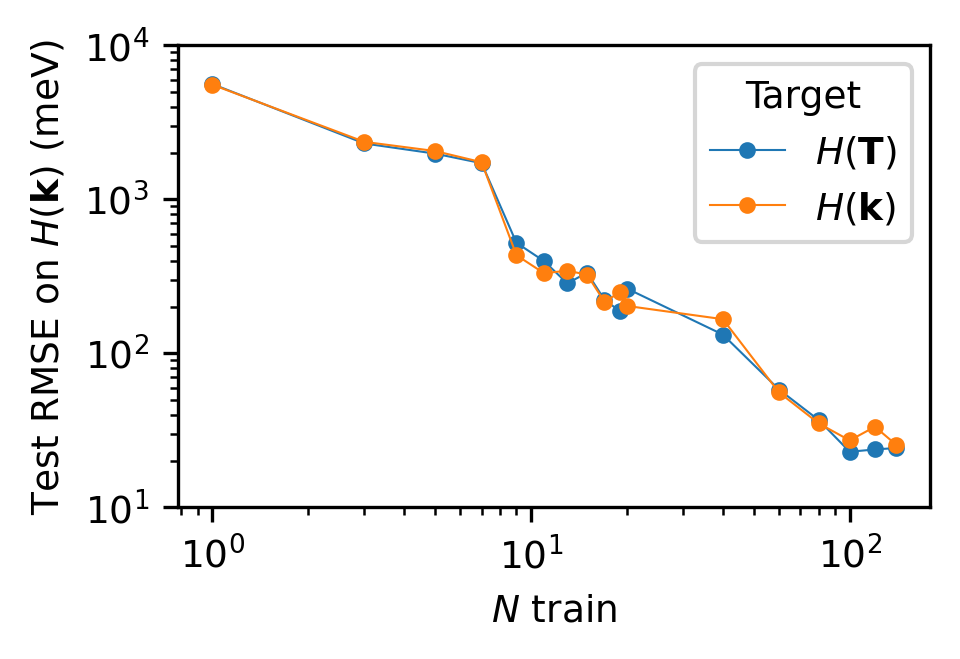

In [27]:
plt.rcParams['font.size'] = 9
fig, ax = plt.subplots()

for space, strategy, name in zip(['real_space', 'kspace'], ['a', 'd'], ['$H(\mathbf{T})$', '$H(\mathbf{k})$']):
    x = np.array([N for N in learning_curve[space][strategy]])
    y = np.array([learning_curve[space][strategy][N]['matrix'] for N in learning_curve[space][strategy]])*Hartree*1000
    ax.loglog(x, y, '-o', lw = 0.5, markersize = 3, label = name)

ax.set_ylim(10,1e4)
ax.legend(title = 'Target')
ax.set_xlabel(r'$N$ train')
ax.set_ylabel(r'Test RMSE on $H(\mathbf{k})$ (meV)')

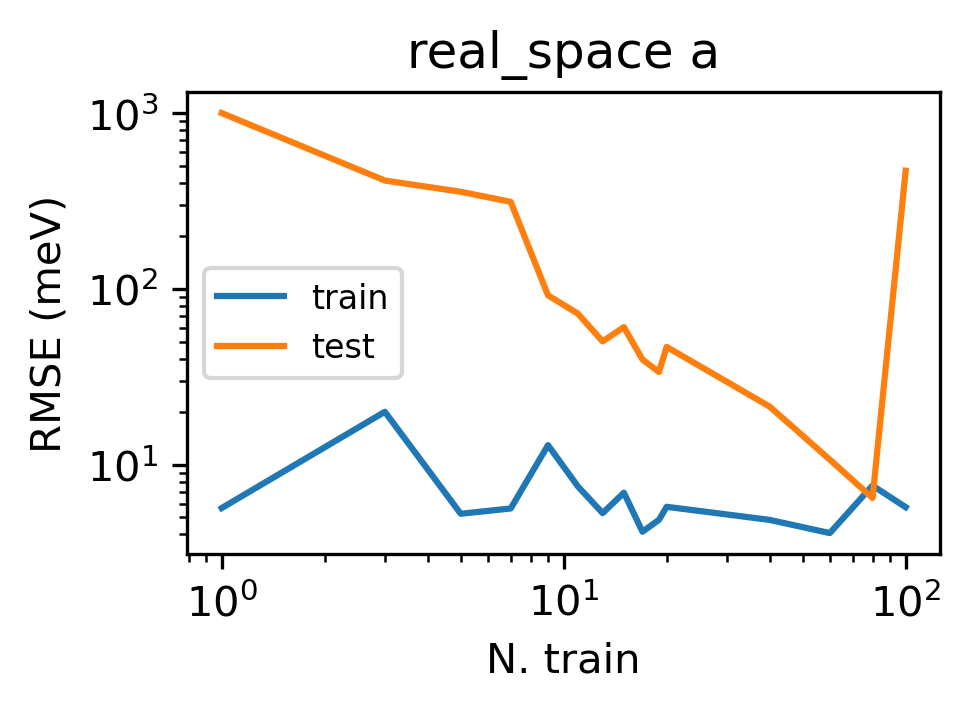

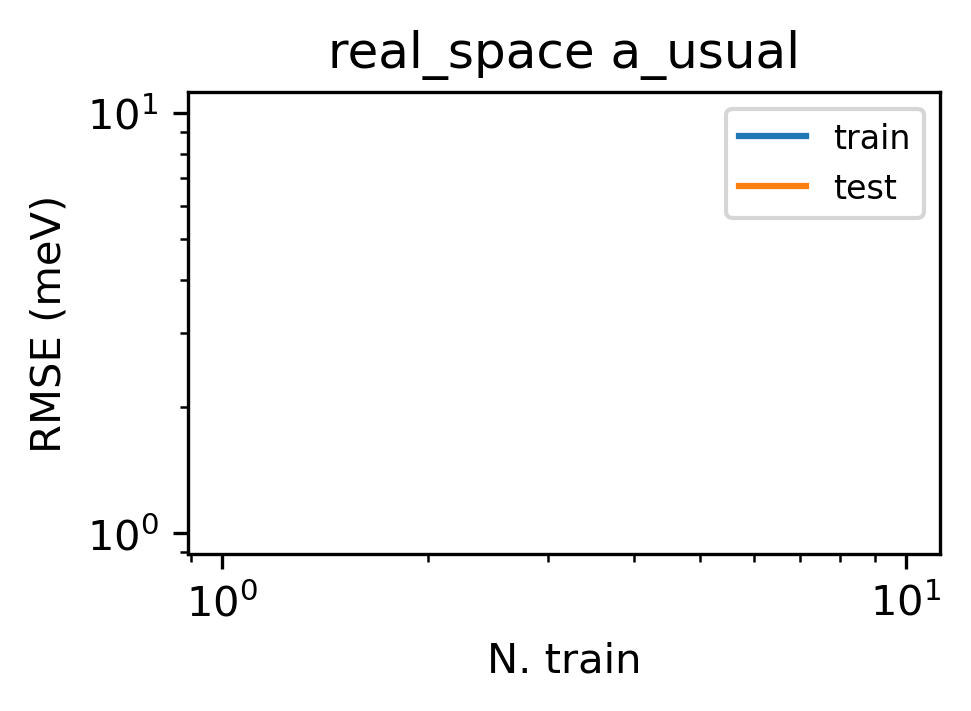

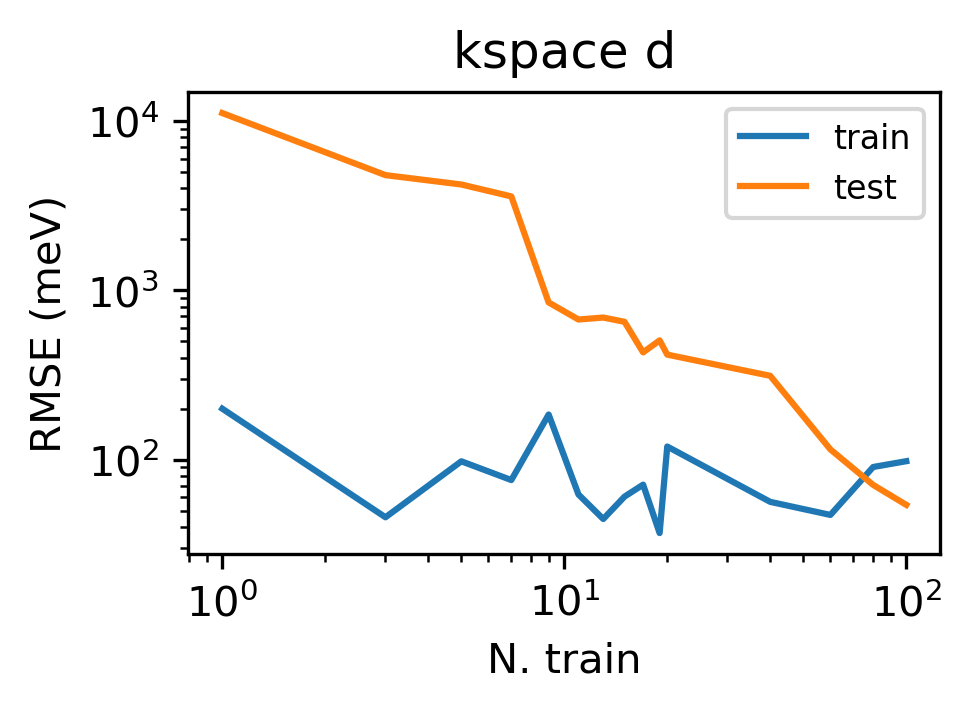

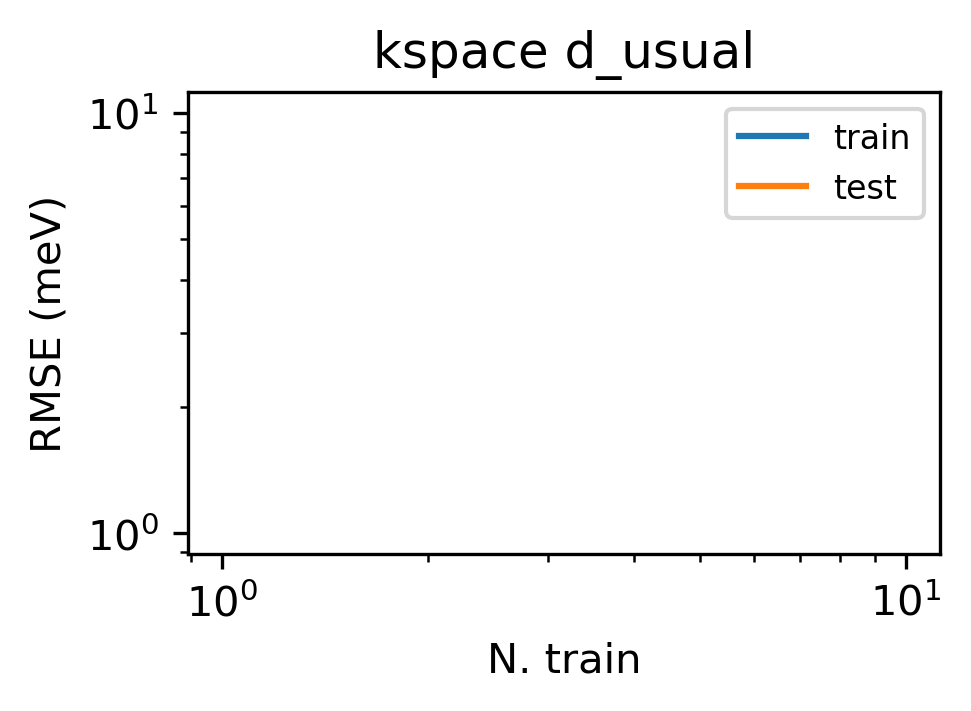

In [77]:
from ase.units import Hartree

for space in eigenvalues:
    
    for strategy in eigenvalues[space]:
        fig, ax = plt.subplots()

        x = np.array([N for N in learning_curve[space][strategy]])
        for dset in ['train', 'test']:
            y = np.array([learning_curve[space][strategy][N][dset] for N in learning_curve[space][strategy]])*Hartree*1000
            ax.loglog(x, y, '-', markersize = 3, alpha = 1, label = dset)
            
        ax.set_title(f'{space} {strategy}')
        ax.legend(fontsize = 8)
        ax.set_xlabel('N. train')
        ax.set_ylabel('RMSE (meV)')

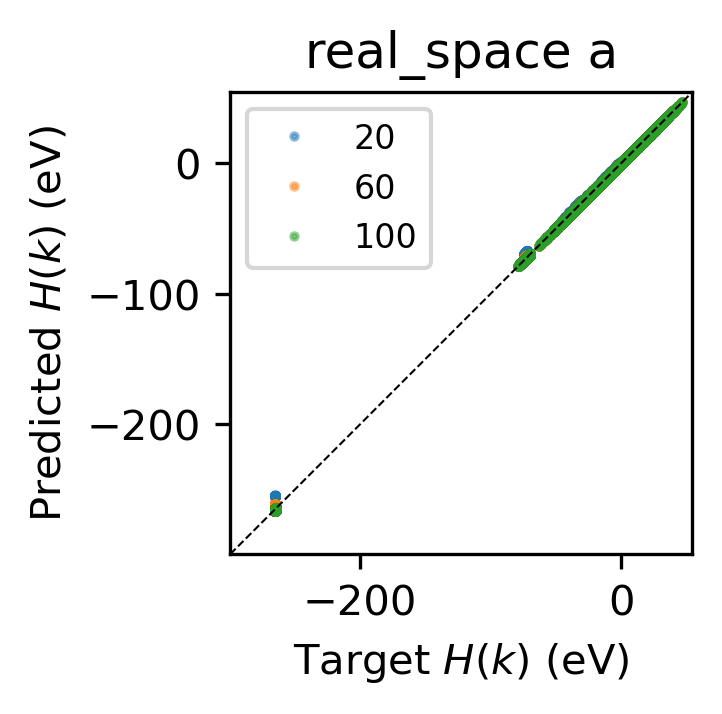

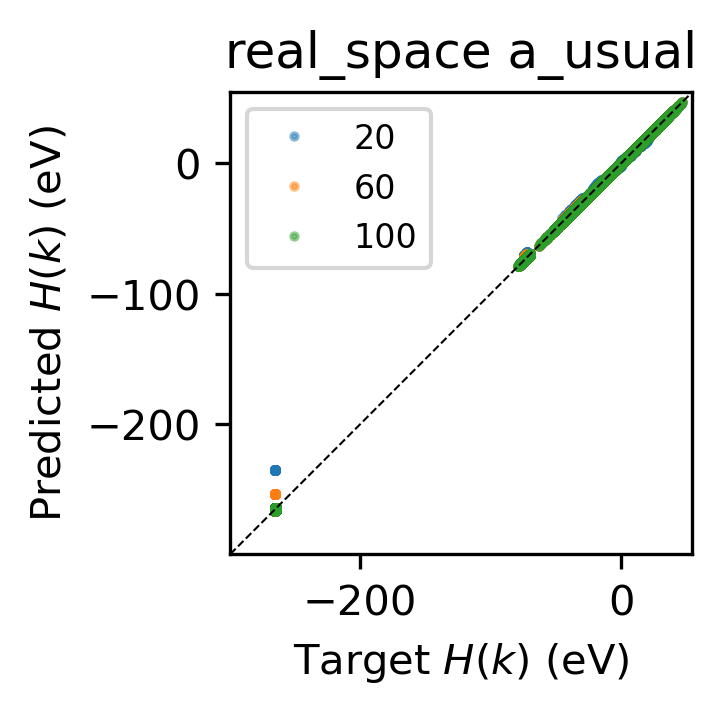

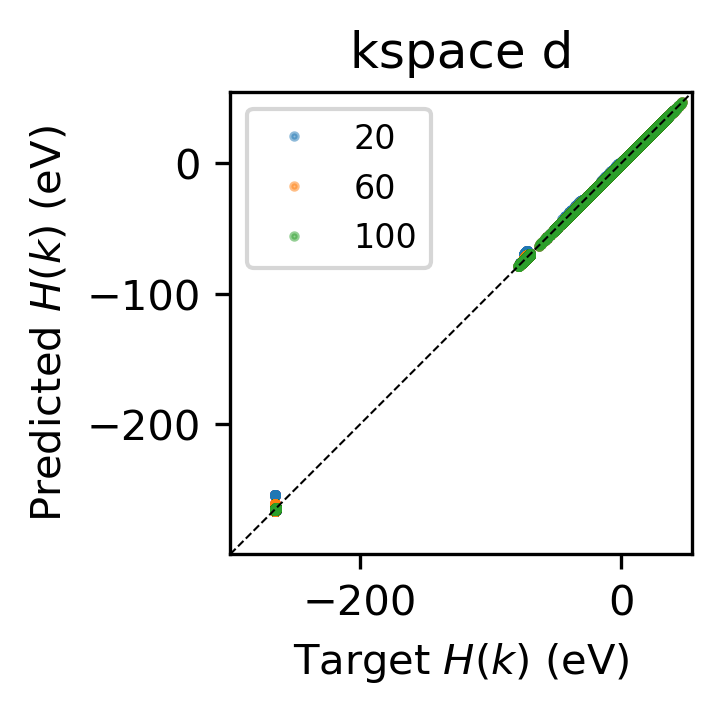

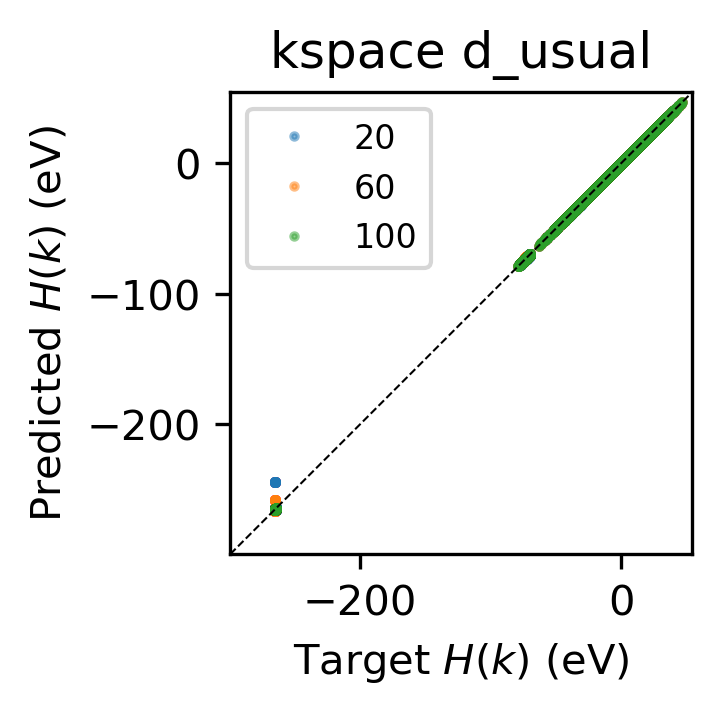

In [169]:
from ase.units import Hartree

x = torch.stack(test_Hk).flatten() * Hartree

for space in eigenvalues:
    
    for strategy in eigenvalues[space]:
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        for N in eigenvalues[space][strategy]:
            y = torch.stack(predicted_Hk[space][strategy][N]).flatten() * Hartree
            # for x, y in zip(test_eigenvalues, eigenvalues[space][strategy][N]): 
            ax.plot(x.real, y.real, '.', markersize = 3, label = N, alpha = 0.5)

        ax.set_title(f'{space} {strategy}')
        ax.legend(fontsize = 8)
        xmin = -11*Hartree
        xmax = 2*Hartree
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(xmin, xmax)
        ax.plot([xmin, xmax], [xmin, xmax], '--k', lw = 0.5)
        ax.set_xlabel('Target $H(k)$ (eV)')
        ax.set_ylabel('Predicted $H(k)$ (eV)')

        # fig.savefig(f'{resdir}/parity_hamiltonian_{space}_{strategy}.png', dpi = 300, bbox_inches = 'tight')

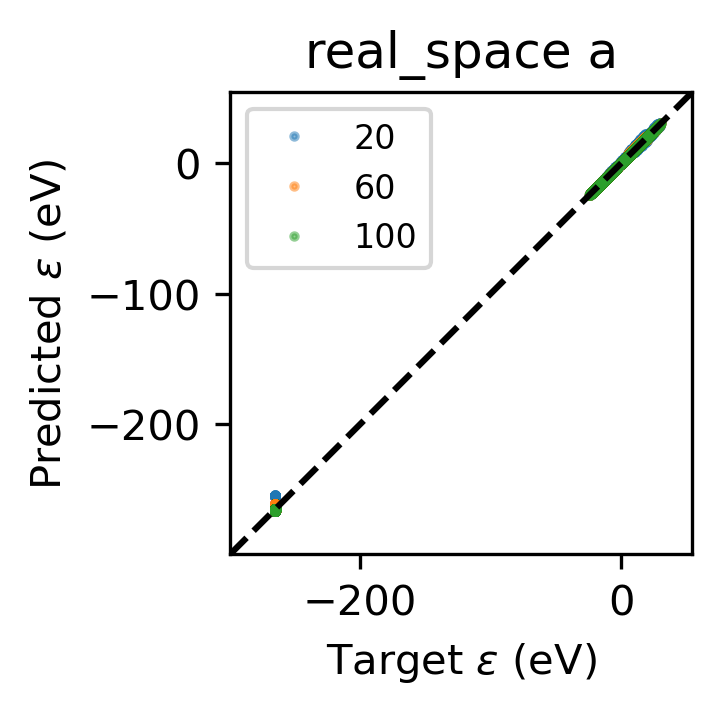

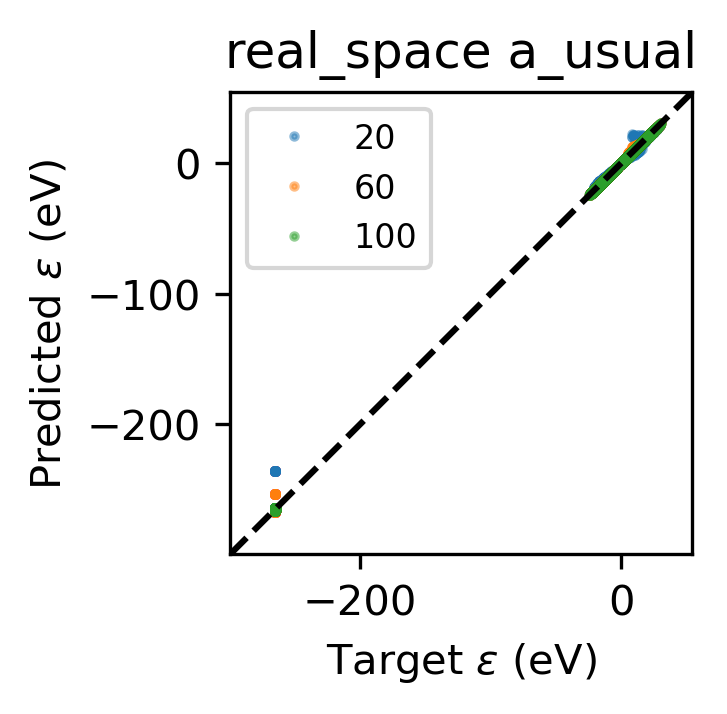

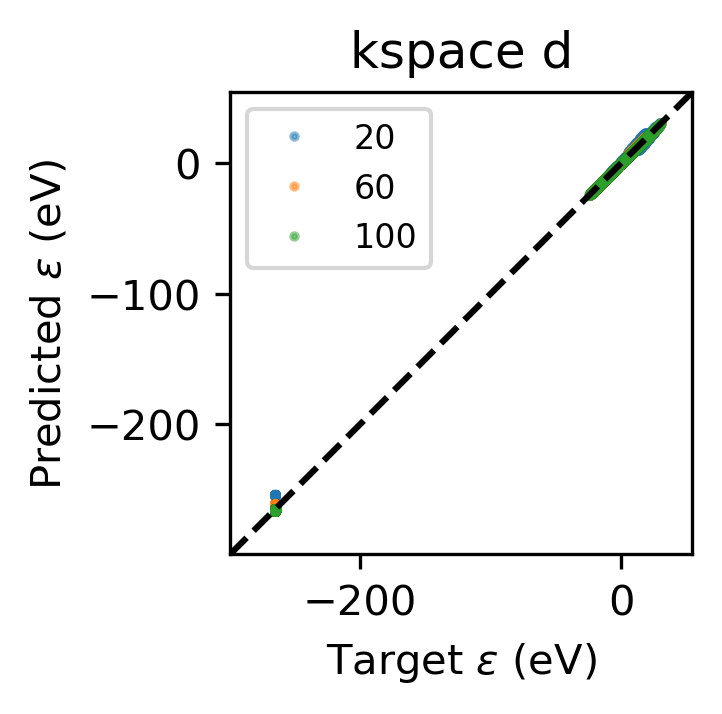

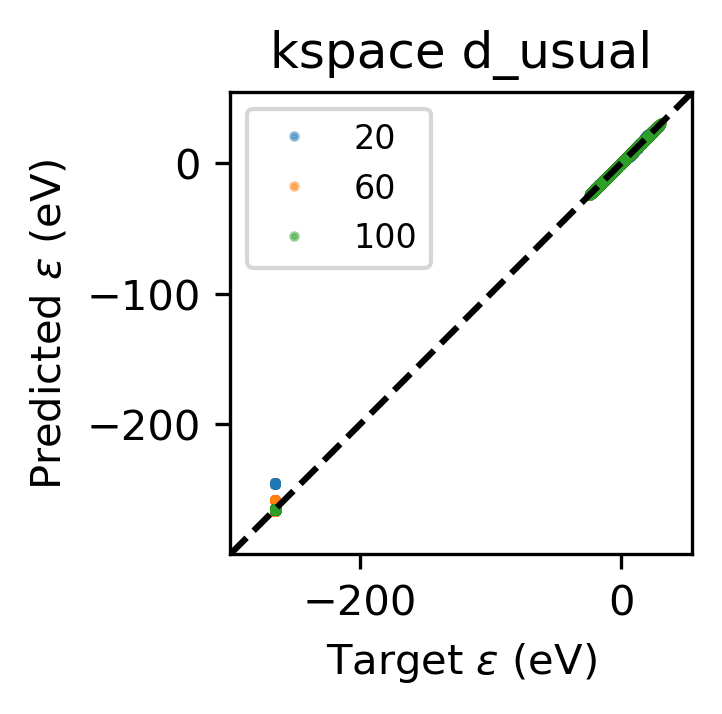

In [170]:
from ase.units import Hartree

x = test_eigenvalues.flatten() * Hartree

for space in eigenvalues:
    
    for strategy in eigenvalues[space]:
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        for N in eigenvalues[space][strategy]:
            y = eigenvalues[space][strategy][N].flatten() * Hartree
            # for x, y in zip(test_eigenvalues, eigenvalues[space][strategy][N]): 
            ax.plot(x, y, '.', markersize = 3, label = N, alpha = 0.5)

        ax.set_title(f'{space} {strategy}')
        ax.legend(fontsize = 8)
        xmin = -11*Hartree
        xmax = 2*Hartree
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(xmin, xmax)
        ax.plot([xmin, xmax], [xmin, xmax], '--k')
        ax.set_xlabel('Target $\epsilon$ (eV)')
        ax.set_ylabel('Predicted $\epsilon$ (eV)')

        fig.savefig(f'{resdir}/parity_eigenvalues_{space}_{strategy}.png', dpi = 300, bbox_inches = 'tight')

## Linear vs Nonlinear

In [296]:
aaa = LinearModelPeriodic(twocfeat = test_features,
                            target_blocks = test_coupled_blocks_integrated,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = 4, 
                            nlayers = 1,
                            activation = None,
                            apply_norm = True
                           )
count_parameters(aaa)

17757

In [214]:
nhidden = 16
model = LinearModelPeriodic(twocfeat = test_features,
                            target_blocks = test_coupled_blocks_integrated,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = nhidden, 
                            nlayers = 1,
                            activation = None,
                            apply_norm = True
                           )
ckpt = torch.load('/scratch/pegolo/seed_73/test_integrated_model/real_space/a/trainlin_0_100/model_1180.ckpt')
model.load_state_dict(ckpt['model_state_dict'])
prediction = model.predict(test_features, test_coupled_blocks_integrated)
Hk = dataset.bloch_sum(blocks_to_matrix(prediction, dataset, detach = True))

ev_ = []
for H, S in zip(Hk, Sk):
    ev__ = []
    for ik in range(len(H)):
        ev__.append(eigvalsh(H[ik].detach().numpy(), S[ik]))
    ev_.append(ev__)
eigenvalues_lin = np.array(ev_) 
predicted_Hk_lin = Hk

In [227]:
test_eigenvalues.shape

(32, 64, 10)

In [231]:
eigenvalues_lin.shape

(32, 64, 10)

Text(0, 0.5, 'Predicted $\\epsilon$ (eV)')

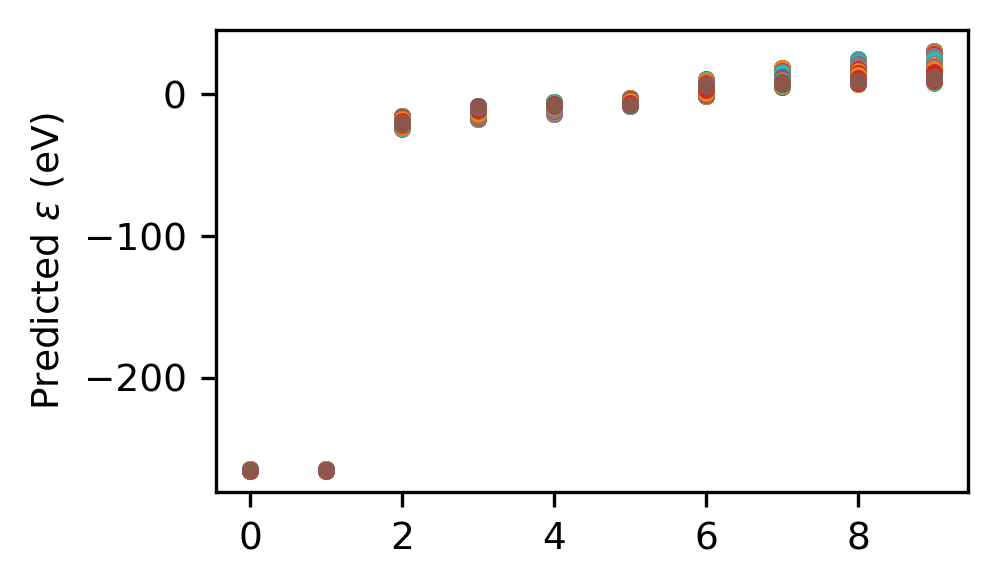

In [285]:
fig, ax = plt.subplots()
# ax.set_aspect('equal')

N = 100
space = 'real_space'
strategy = 'a'

xx = test_eigenvalues * Hartree

yy = eigenvalues_lin * Hartree

# for ifr, (x, y) in enumerate(zip(xx, yy)):
#     # if ifr == 0:
#         for ik in range(len(x)):
#             # if ik == 10:
#                 v = np.abs(x[ik]-y[ik]) #/(x[ik]+1e-4)
#                 ax.plot(v, '.', markersize = 1, label = ifr, alpha = 0.5)

yy = eigenvalues[space][strategy][N] * Hartree

# plt.plot(xx.flatten(), '.')
# plt.plot(yy.flatten(), '.')

for ifr, (x, y) in enumerate(zip(xx, yy)):
    # if ifr == 0:
        for ik in range(len(x)):
            # if ik == 10:
                # v = np.abs(x[ik]-y[ik]) #/(x[ik]+1e-4)
                # ax.plot(v, 'D', markersize = 1, label = ifr, alpha = 0.5)
                ax.plot(x[ik], '.')
                ax.plot(y[ik], '.')

# for x, y in zip(xx, yy):
#     ax.plot(np.abs(x-y).flatten(), '.', markersize = 1, label = 'Nonlinear', alpha = 0.5)

# ax.legend(fontsize = 8, loc = 'center left', bbox_to_anchor = (1, 0.5))
xmin = -11*Hartree
xmax = 2*Hartree
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(xmin, xmax)
# ax.plot([xmin, xmax], [xmin, xmax], '--k')
ax.set_xlabel('')
ax.set_ylabel('Predicted $\epsilon$ (eV)')

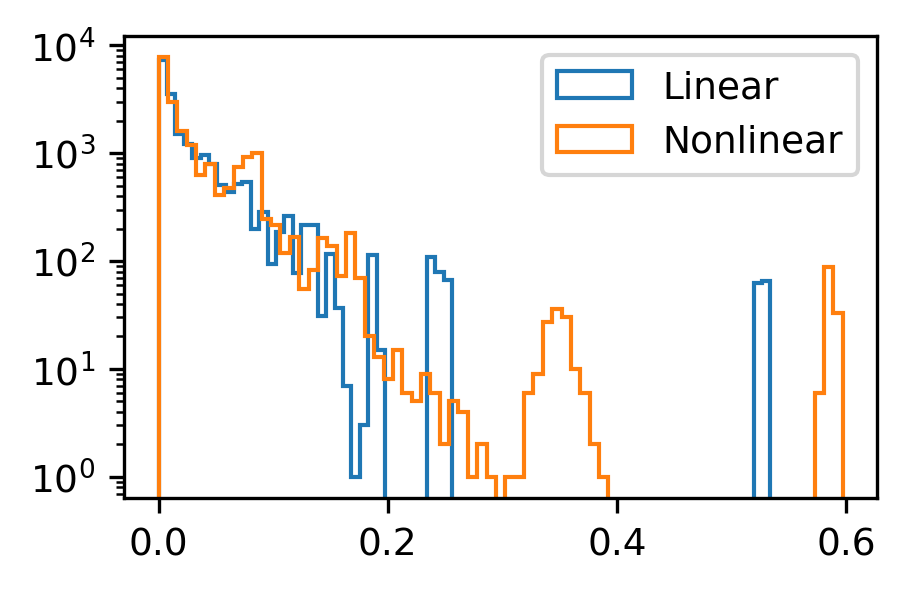

In [293]:
xx = test_eigenvalues * Hartree
yy = eigenvalues_lin * Hartree
plt.hist(np.abs(xx-yy).flatten(), bins = 'scott', histtype='step', label = 'Linear');

yy = eigenvalues[space][strategy][N] * Hartree
plt.hist(np.abs(xx-yy).flatten(), bins = 'scott', histtype='step', label = 'Nonlinear');

plt.legend()
plt.yscale('log')

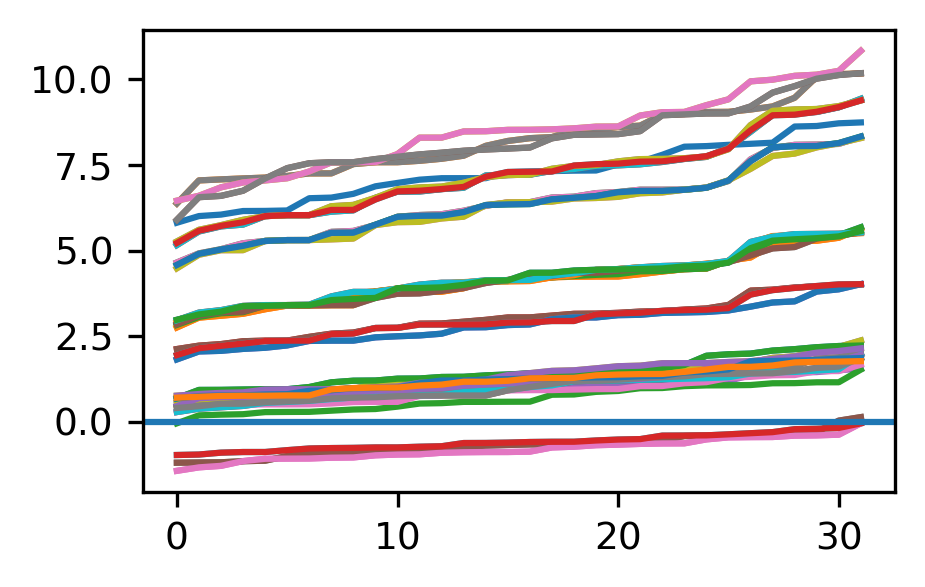

In [279]:
for i in range(6,7):
    for ik in range(64):
        plt.plot(np.sort(xx[:, ik, i].flatten()), label = i)
plt.axhline(0)
# plt.legend()

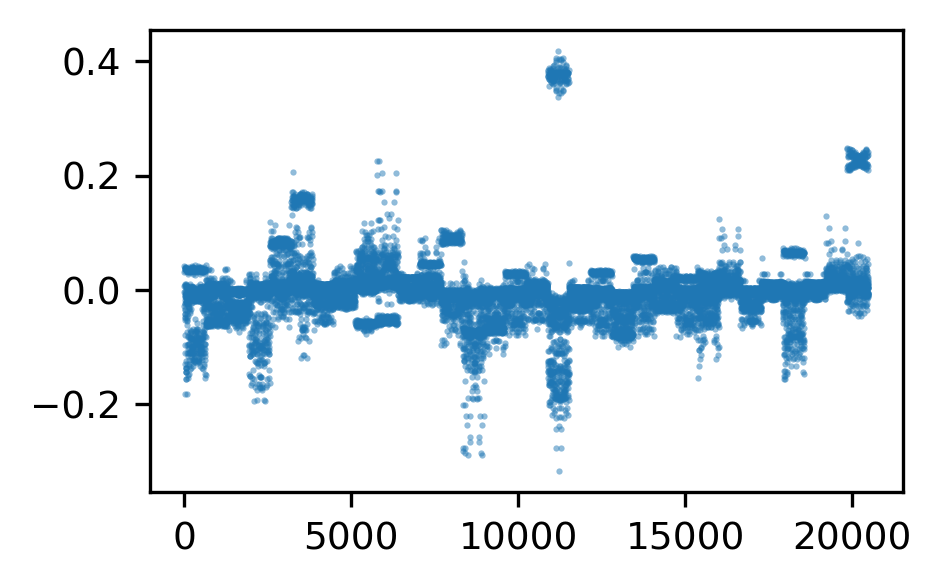

In [220]:
x = eigenvalues_lin.flatten() * Hartree
y = eigenvalues[space][strategy][N].flatten() * Hartree

plt.plot(x-y, '.', markersize = 1, label = N, alpha = 0.5)

# Error propagation on the core eigenvalues

In [148]:
test_HT = blocks_to_matrix(test_coupled_blocks, dataset, detach = True)

In [144]:
h_Gamma = test_Hk[0][0].real
s_Gamma = Sk[0][0].real

In [145]:
eigv = eigvalsh(h_Gamma, s_Gamma)

In [161]:
scale = 4e-3
HT_noise = {}
for T in test_HT[0]:
    noise = torch.randn_like(test_HT[0][T])*scale 
    noise = 0.5*(noise+noise.T)
    HT_noise[T] = test_HT[0][T] + noise
h_Gamma_gaussnoise = dataset.bloch_sum([HT_noise])[0][0]
# h_Gamma_gaussnoise = h_Gamma + torch.randn_like(h_Gamma)*scale
eigv_gaussnoise = eigvalsh(h_Gamma_gaussnoise, s_Gamma)

Text(0, 0.5, 'Predicted $\\epsilon$ (eV)')

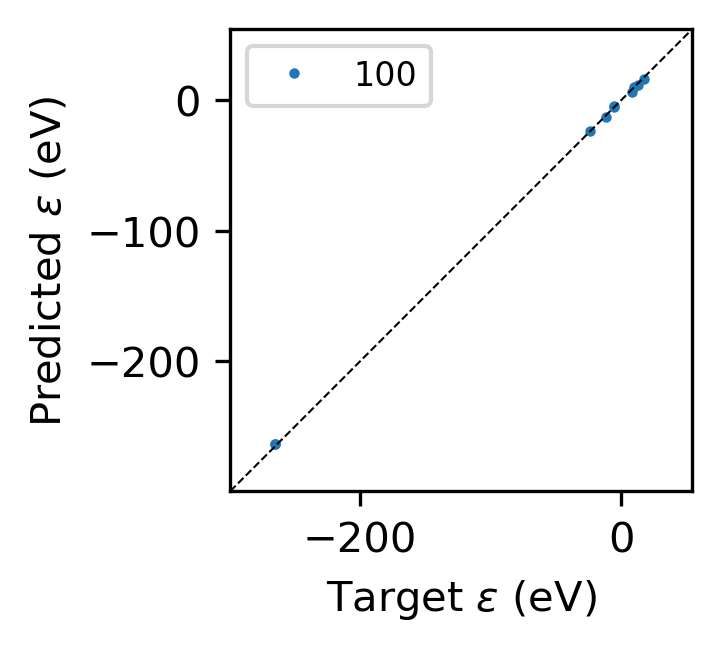

In [162]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
x = eigv * Hartree
y = eigv_gaussnoise * Hartree
ax.plot(x, y, '.', markersize = 3, label = N, alpha = 1)

ax.legend(fontsize = 8)
xmin = -11*Hartree
xmax = 2*Hartree
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.plot([xmin, xmax], [xmin, xmax], '--k', lw = 0.5)
ax.set_xlabel('Target $\epsilon$ (eV)')
ax.set_ylabel('Predicted $\epsilon$ (eV)')

In [165]:
ee=eigvalsh(s_Gamma)
ee[-1]/ee[0]

26.908514033393484

# MoS2

In [29]:
root = '/scratch/pegolo/mos2'
workdir = f'{root}/learning_curve'

In [30]:
nhidden = 16
nlayers = 1
device = 'cpu'
cutoff = 8
overwrite = True

results_dir = f'{root}/test_results'
Path(results_dir).mkdir(exist_ok = overwrite)

device = 'cpu'
orbitals = {
     'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]},
     'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
     'gthszvmolopt': {
         6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]],

         16: [[3,0,0],
              [3,1,-1], [3,1,0], [3,1,1]],

         42: [[4,0,0],
              [5,0,0],
              [4,1,-1], [4,1,0], [4,1,1],
              [4, 2, -2], [4, 2, -1], [4, 2, 0], [4, 2, 1], [4, 2, 2]]
         }
 }
orbital_names = 'gthszvmolopt'

kmesh = [1,1,1]

## Load checkpoints

In [31]:
checkpoints = {}

start = 0

stops = sorted([int(s.split('/')[-1].split('_')[-1]) for s in glob(f'{workdir}/models_{start}_*')])

for stop in stops:
    folder = f'{workdir}/models_{start}_{stop}'
    try:
        nbest = max([int(f.split('/')[-1].split('.')[0].split('_')[1]) for f in glob(f'{folder}/model*ckpt')])
        print(stop, nbest)
        checkpoints[stop] = torch.load(f'{folder}/model_{nbest}.ckpt')
    except:
        print(f'No useful data in {folder}')

10 1150
20 960
30 940
40 1160
50 1280


## Test dataset

In [32]:
# Features
indices = range(80,90)
frames = read(f'{root}/data/deepH_MoS2.xyz', index = '80:90')
rfock = [np.load(f"{root}/data/SVB/{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rfock0 = [np.load(f"{root}/data/SVB_baseline/{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rover = [np.load(f"{root}/data/SVB/{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in indices]

for f in frames:
    f.pbc = [True,True,False]
    f.wrap(center = (0,0,0), eps = 1e-60)
    f.pbc = True

test_dataset = QMDataset(frames = frames,
                               kmesh = [1,1,1],
                               dimension = 2,
                               fock_realspace = rfock,
                               overlap_realspace = rover,
                               device = device,
                               orbs = orbitals[orbital_names],
                               orbs_name = orbital_names + '-sr')

test_dataset0 = QMDataset(frames = frames,
                               kmesh = [1,1,1],
                               dimension = 2,
                               fock_realspace = rfock0,
                               overlap_realspace = rover,
                               device = device,
                               orbs = orbitals[orbital_names],
                               orbs_name = orbital_names + '-sr')

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.

WARN

In [33]:
_, test_coupled_blocks = get_targets(test_dataset, cutoff = 8)
_, overlap_blocks = get_targets(test_dataset, cutoff = 8, target = 'overlap')
_, test_coupled_blocks0 = get_targets(test_dataset0, cutoff = 8)

In [34]:
test_Hk = test_dataset.bloch_sum(blocks_to_matrix(test_coupled_blocks, test_dataset)) 
H0k = test_dataset0.bloch_sum(blocks_to_matrix(test_coupled_blocks0, test_dataset0))

# for h, h0 in zip(test_Hk, H0k):
#     h -= h0
Sk = test_dataset.bloch_sum(blocks_to_matrix(overlap_blocks, test_dataset)) 

## Test targets

In [35]:
ntest = sum([np.prod(b.values.shape) for b in test_coupled_blocks.blocks()])

In [36]:
target_keynames = test_coupled_blocks.keys.names
keys = []
blocks= []
for k,b in test_coupled_blocks.items(): 
    li,lj, L = k['l_i'], k['l_j'], k['L']
    inversion_sigma = (-1) ** (li + lj + L)
    keys.append(torch.cat((k.values, torch.tensor([inversion_sigma]))))
    blocks.append(b.copy())
test_coupled_blocks_integrated = TensorMap(Labels(k.names+['inversion_sigma'], torch.stack(keys)), blocks)
test_coupled_blocks_integrated_copy = test_coupled_blocks_integrated.copy()
test_coupled_blocks_integrated = test_coupled_blocks_integrated.keys_to_properties(['n_i', 'l_i',  'n_j','l_j'])

In [37]:
ev_ = []
for H, S in zip(test_Hk, Sk):
    ev__ = []
    for ik in range(len(H)):
        ev__.append(eigvalsh(H[ik].detach().numpy(), S[ik]))
    ev_.append(ev__)
test_eigenvalues = np.array(ev_)

In [38]:
ev_ = []
for H, S in zip(H0k, Sk):
    ev__ = []
    for ik in range(len(H)):
        ev__.append(eigvalsh(H[ik].detach().numpy(), S[ik]))
    ev_.append(ev__)
test_eigenvalues0 = np.array(ev_)

## Test features

In [39]:
test_features = mts.load(f'{root}/test/features_80_90')

# Models performance

In [55]:
from mlelec.models.linear_integrated import LinearModelPeriodic
nhidden = 16
model = LinearModelPeriodic(twocfeat = test_features,
                            target_blocks = test_coupled_blocks_integrated,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = nhidden, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                                       )

print(f'Integrated model with {count_parameters(model)} parameters.')

Integrated model with 905346 parameters.


In [109]:
eigenvalues = {}
predicted_Hk = {}
learning_curve = {}

           
for N in checkpoints:
    
    ckpt = checkpoints[N]
    print(f'   {N}', ckpt['epoch'])

    # try:
    if True:
        model.load_state_dict(ckpt['model_state_dict'])
        prediction = model.predict(test_features, test_coupled_blocks_integrated)

        Hk = test_dataset.bloch_sum(blocks_to_matrix(prediction, test_dataset, detach = True))
        ev_ = []
        for ifr in range(len(Hk)):
        # for H, H0, S in zip(Hk, H0k, Sk):
            Hk[ifr] = Hk[ifr] + H0k[ifr]
            ev__ = []
            for ik in range(len(Hk[ifr])):
                ev__.append(eigvalsh(Hk[ifr][ik].detach().numpy(), Sk[ifr][ik]))
            ev_.append(ev__)
        eigenvalues[N] = np.array(ev_) 
        predicted_Hk[N] = Hk

        n = sum([np.prod(b.values.shape) for b in prediction.blocks()])
        learning_curve[N] = {'train': np.sqrt(ckpt['loss']/n), 
                              'test': np.sqrt(L2_loss(prediction, test_coupled_blocks_integrated).item()/ntest), 
                              'matrix': np.sqrt(torch.mean(torch.abs((torch.stack(Hk) - torch.stack(test_Hk)).flatten())**2).item())}           

        print(f'    Real loss: {L2_loss(prediction, test_coupled_blocks_integrated).item():.5f}')
    # except Exception as e:
    #     print('nope', e)
print()

   10 1150
    Real loss: 2886.69310
   20 960
    Real loss: 2887.03223
   30 940
    Real loss: 2887.06808
   40 1160
    Real loss: 2887.12451
   50 1280
    Real loss: 2886.98700



Text(0, 0.5, 'Test RMSE on $H(\\mathbf{k})$ (meV)')

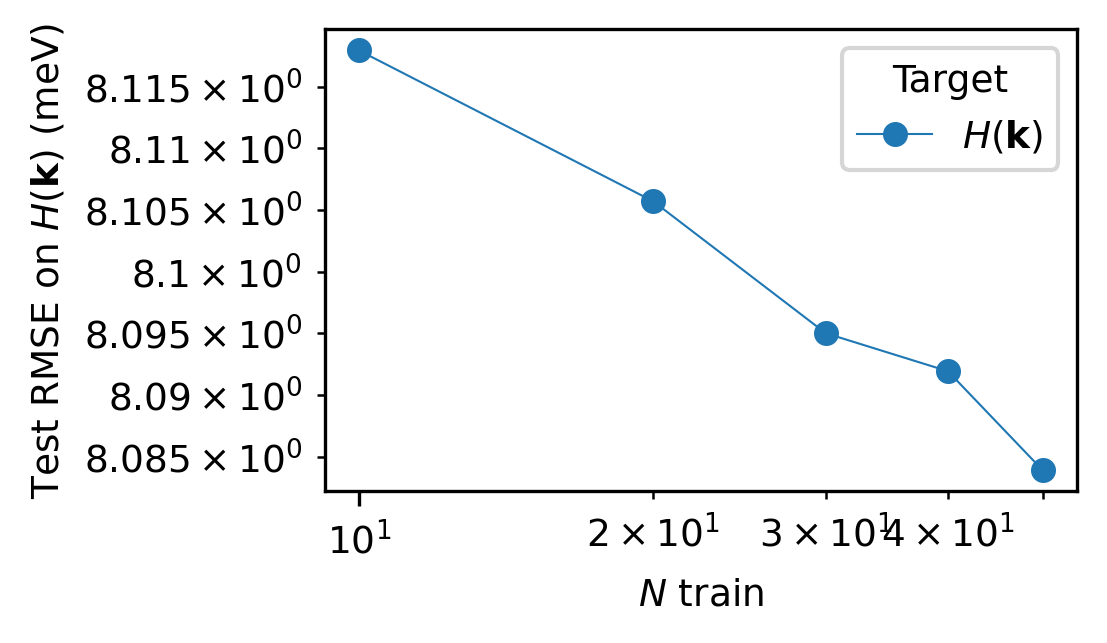

In [110]:
plt.rcParams['font.size'] = 9
fig, ax = plt.subplots()

x = np.array([N for N in learning_curve])
y = np.array([learning_curve[N]['matrix'] for N in learning_curve])*Hartree*1000
ax.loglog(x, y, '-o', lw = 0.5, markersize = 5, label = name)

ax.legend(title = 'Target')
ax.set_xlabel(r'$N$ train')
ax.set_ylabel(r'Test RMSE on $H(\mathbf{k})$ (meV)')
# ax.set_ylim(10,10000)

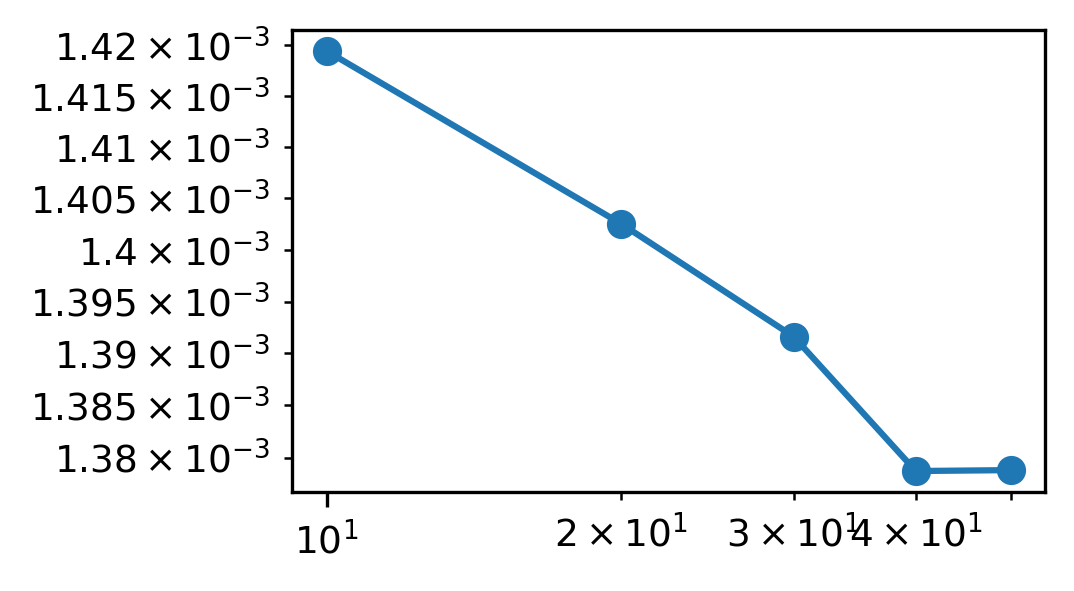

In [101]:
x = np.array([N for N in eigenvalues])
y = np.array([np.sqrt(np.mean((eigenvalues[N] - test_eigenvalues).flatten()**2)) for N in eigenvalues])
plt.loglog(x,y, '-o')
# plt.ylim(1e-4,1e-1)

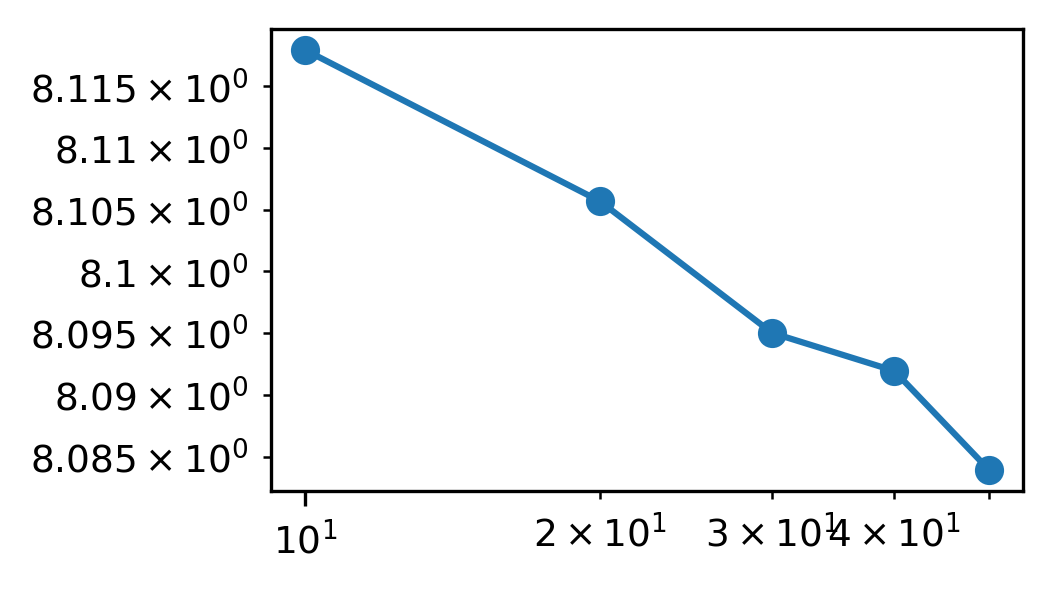

In [112]:
x = np.array([N for N in predicted_Hk])
y = np.array([np.sqrt(torch.mean(torch.abs(torch.stack(predicted_Hk[N]) - torch.stack(test_Hk)).flatten()**2)) for N in predicted_Hk]) * Hartree * 1000
plt.loglog(x,y, '-o')

In [183]:
np.vstack([eigenvalues[10].flatten(), test_eigenvalues]).shape

(20, 1, 450)

In [186]:
eee = {'prediction_au': eigenvalues, 'target_au': test_eigenvalues}

In [189]:
np.save('/scratch/pegolo/samsung_report_2024_06/data/MoS2_eigenvalues.npy', eee)

In [184]:
eigenvalues[10].shape

(10, 1, 450)

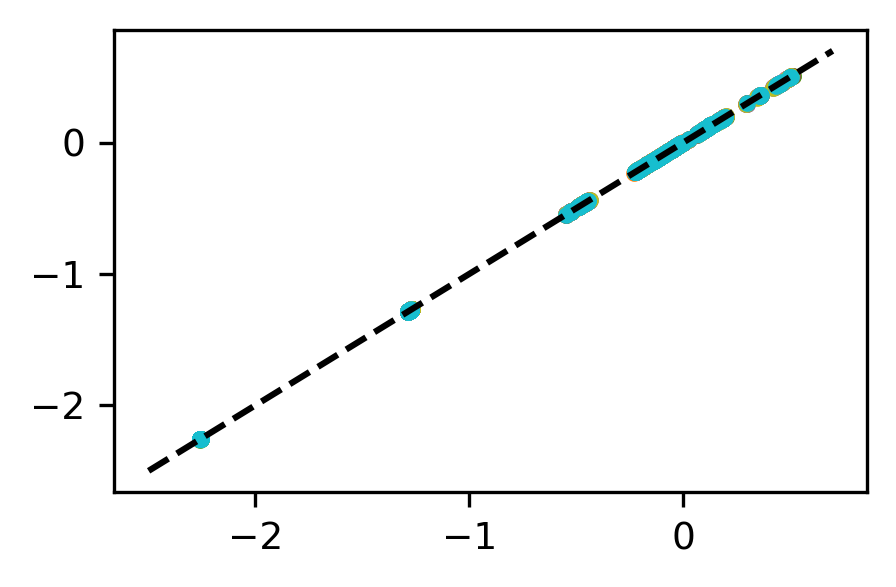

In [222]:
fig, ax = plt.subplots()

for x, y in zip(eigenvalues[10], test_eigenvalues):
    plt.plot(x.flatten(), y.flatten(), '.')
plt.plot([-2.5, .7], [-2.5, .7], '--k')

In [173]:
pl[2][0].get_edgecolor()

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1)

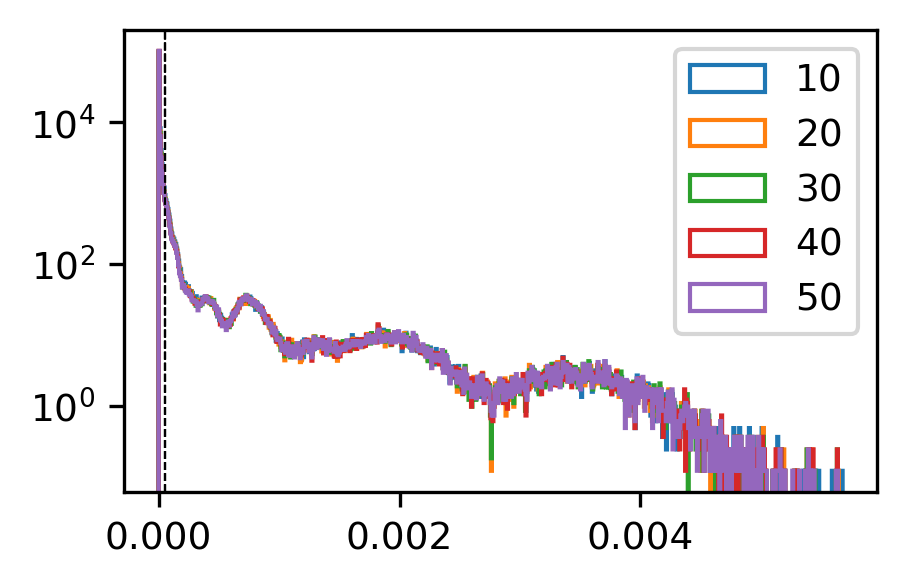

In [181]:
fig, ax = plt.subplots()

for N in predicted_Hk:
    h = torch.abs(torch.stack(predicted_Hk[N]) - torch.stack(test_Hk)).flatten()
    pl = ax.hist(h.numpy(), bins = 'scott', density = True, alpha = 1, label = N, histtype = 'step');
    ax.axvline(torch.mean(h), 
               color = 'k', 
               # color = pl[2][0].get_edgecolor(), 
               lw = 0.5, ls = '--')
    
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(0,)
ax.legend()

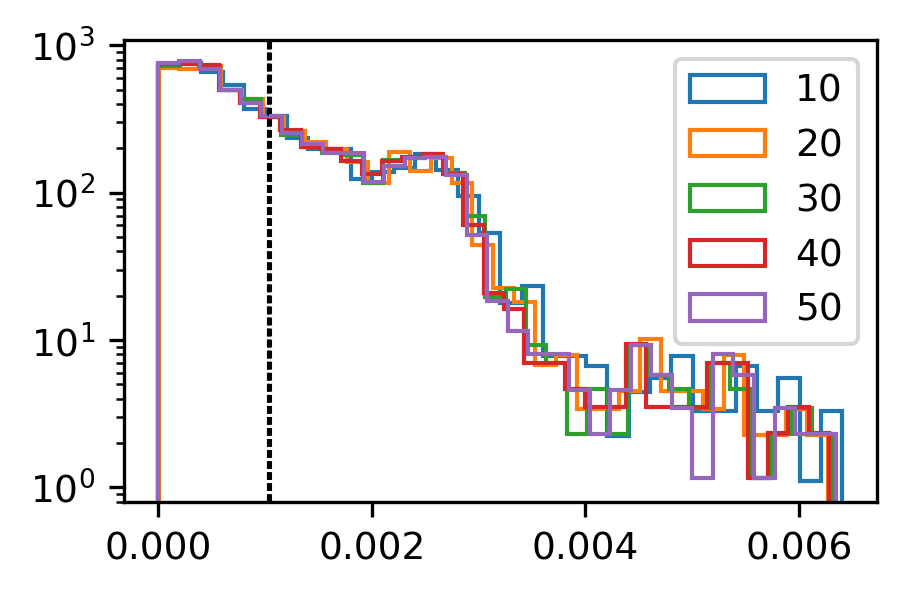

In [179]:
fig, ax = plt.subplots()

for N in eigenvalues:
    h = np.abs(eigenvalues[N] - test_eigenvalues).flatten()
    ax.hist(h, bins = 'scott', density = True, alpha = 1, label = N, histtype = 'step');
    ax.axvline(np.mean(h), 
               color = 'k', 
               # color = pl[2][0].get_edgecolor(), 
               lw = 0.5, ls = '--')# ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()


KeyboardInterrupt



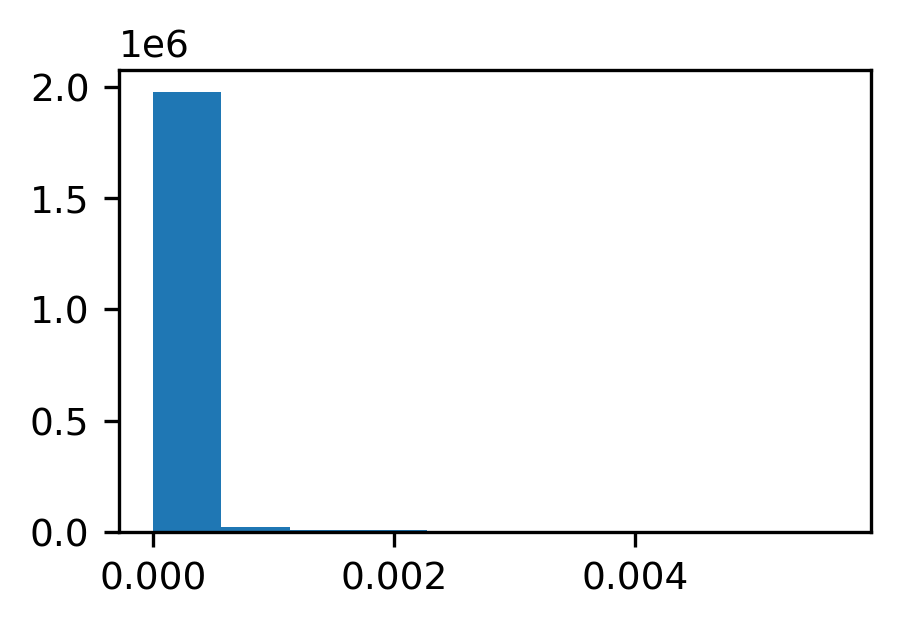

In [115]:
for h in [np.sqrt(torch.abs(torch.stack(predicted_Hk[N]) - torch.stack(test_Hk)).flatten()**2) for N in predicted_Hk]:
    plt.hist(h.flatten())

In [54]:
Hk[0].real[0]

tensor([[-9.6573e-02,  3.2298e-02, -4.7423e-04,  ...,  7.0816e-06,
          2.0638e-06,  7.9231e-06],
        [ 3.2298e-02, -6.4312e-02,  4.4570e-04,  ..., -9.6018e-04,
          1.5531e-03, -1.5585e-03],
        [-4.7423e-04,  4.4570e-04, -9.2018e-02,  ...,  0.0000e+00,
         -2.5377e-07, -4.9445e-08],
        ...,
        [ 7.0816e-06, -9.6018e-04,  0.0000e+00,  ..., -4.3052e-02,
         -2.0266e-04,  2.8294e-04],
        [ 2.0638e-06,  1.5531e-03, -2.5377e-07,  ..., -2.0266e-04,
         -3.8243e-02, -3.8194e-05],
        [ 7.9231e-06, -1.5585e-03, -4.9445e-08,  ...,  2.8294e-04,
         -3.8194e-05, -4.2878e-02]])

In [204]:
predicted_Hk[50][0] - Hk[0]

tensor([[[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         ...,
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]]])

In [103]:
print(f'{torch.mean(torch.abs((torch.stack(Hk) - torch.stack(test_Hk)).flatten())).item()*Hartree*1000:.3e}')

1.346e+00


In [104]:
np.sqrt(np.mean(np.abs(eigenvalues[50]-test_eigenvalues)**2)) / np.std(test_eigenvalues) * 100

0.20389371725790242

In [105]:
np.mean(np.abs(eigenvalues[50]-test_eigenvalues)) / np.std(test_eigenvalues) * 100

0.1514484362659793

In [106]:
torch.sqrt(torch.mean(torch.abs((torch.stack(predicted_Hk[50]) - torch.stack(test_Hk)).flatten())**2)) / torch.std(torch.stack(test_Hk)) * 100

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [108]:
predicted_Hk[50].shape

torch.Size([1, 450, 450])

In [73]:
torch.mean(torch.abs((torch.stack(predicted_Hk[50]) - torch.stack(test_Hk)).flatten())).item() / torch.std(torch.stack(test_Hk))

tensor(0.1293)

In [96]:
diff = (torch.stack(predicted_Hk[50]) - torch.stack(test_Hk)) #/ torch.stack(test_Hk)

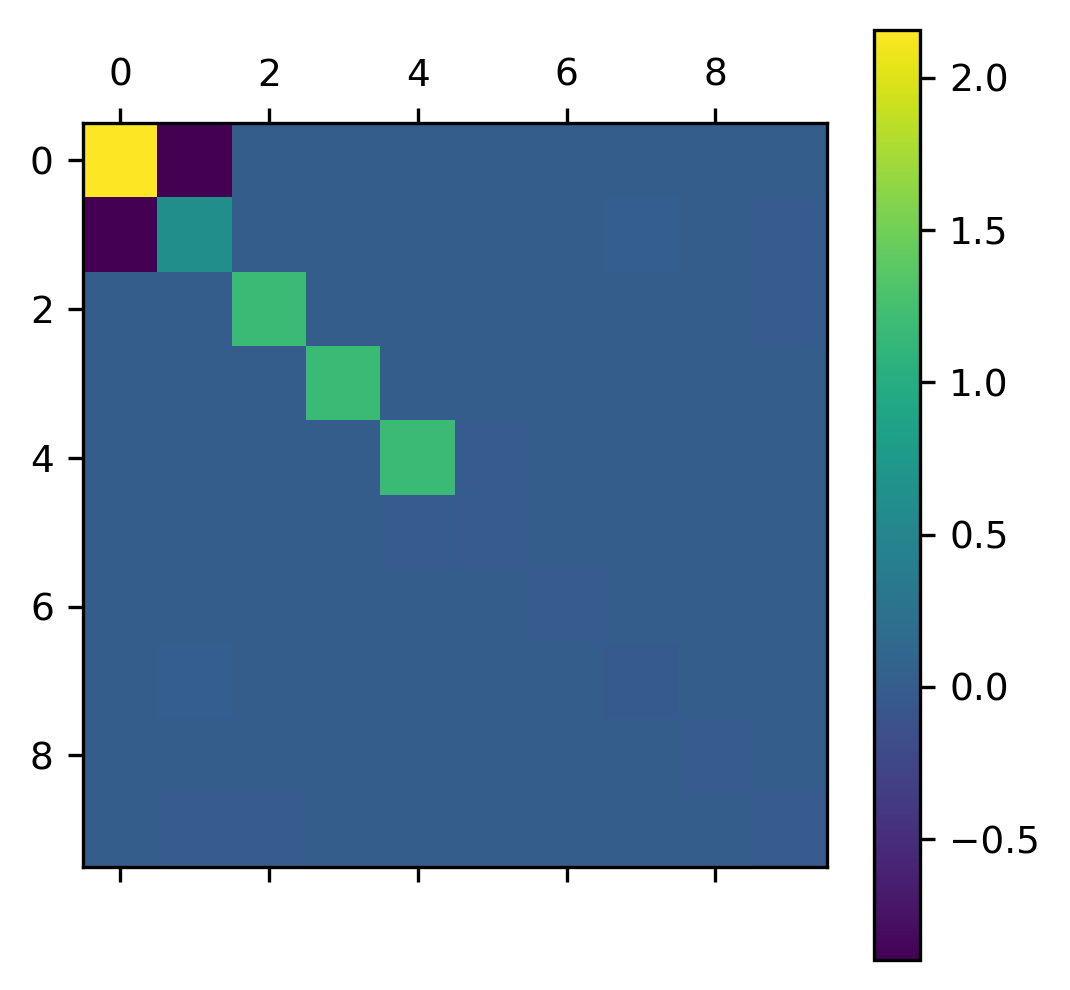

In [90]:
plt.matshow(diff[0,0].real[:10,:10])
plt.colorbar()

In [92]:
diff = eigenvalues[50]-test_eigenvalues

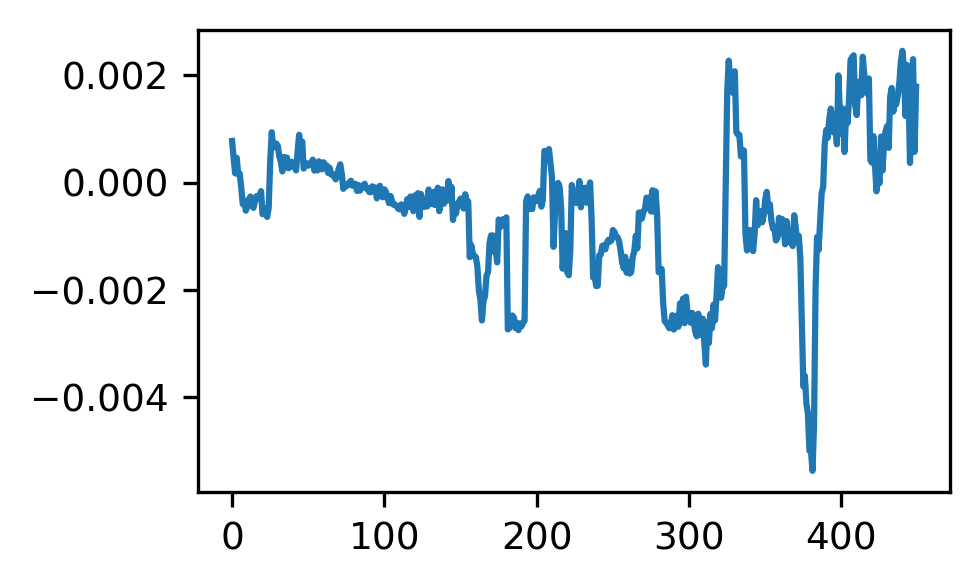

In [94]:
plt.plot(diff[0,0])

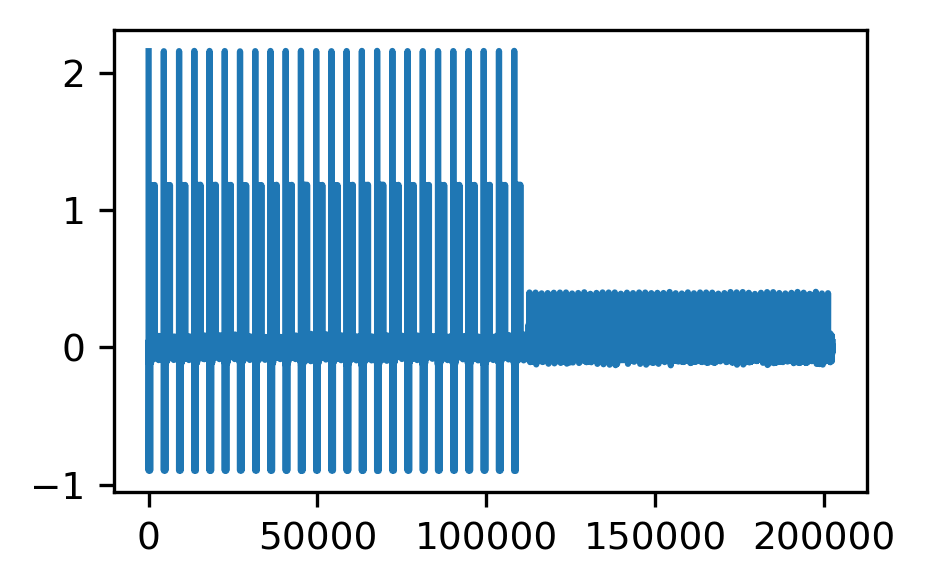

In [97]:
plt.plot(diff[0,0].real.flatten())

In [300]:
dataset.basis

{6: [[1, 0, 0], [2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]]}

In [301]:
dataset.

'sto-3g'